In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import random

In [2]:
def get_random_crop(image, crop_height, crop_width):
    
    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height
    
    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]

    return crop

In [3]:
class XRayCNNDataset(Dataset):
    # root_dir example: r'D:xray/cnn/train'
    # annotation_file example: r'train.csv'
    def __init__(self, root_dir, annotation_file, augment=0):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.augment = augment
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        file_name = self.annotations._get_value(index, 'image_id')
        label = self.annotations._get_value(index, 'class_id')
        file = open(os.path.join(self.root_dir, file_name), 'rb')
#         img = pickle.load(file)
#         img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
#         img = np.array([img.copy(), img.copy(), img.copy()])
        img = pickle.load(file)
        if self.augment == 1:
            if random.random() < 0.5:
                np.fliplr(img)
            if random.random() < 0.5:
                img = cv2.copyMakeBorder(img, 4, 4, 4, 4, cv2.BORDER_REFLECT)
                img = get_random_crop(img, 64, 64)
        img = np.array([img])

        file.close()
        img = img.astype('float32')
        return (img, label)

In [4]:
def get_data(batch_size=128):
    trainset = XRayCNNDataset(r'newTrain', 'newTrain.csv', augment=1)
    trainloader  = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    vset = XRayCNNDataset(r'valid', 'valid.csv')
    vloader  = DataLoader(vset, batch_size=batch_size, shuffle=False)
    
    testset = XRayCNNDataset(r'test', 'test.csv')
    testloader  = DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    classes = ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
               'Consolidation', 'ILD', 'Inflitration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion',
               'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
    return {'train': trainloader, 'test': testloader, 'valid': vloader, 'classes': classes}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = get_data()

In [5]:
def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=0):
    net.to(device)
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    for epoch in tqdm(range(epochs)):
        sum_loss = 0.0
        for i, batch in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch[0].to(device), batch[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize 
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            # print statistics
            losses.append(loss.item())
            sum_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0.0
    return losses

def accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

def anneal(net, data, startingLR=0.001, epochsPerLR=10, momentum=0.9, decay=0.0, numAnnealing=3, verbose=0):
    losses = []
    lr = startingLR
    for i in range(numAnnealing):
        losses += train(net, data, epochsPerLR, lr=lr, momentum=momentum, decay=decay, verbose=verbose)
        lr /= 10
    return losses

In [6]:
class CustomNet5(nn.Module):
    def __init__(self):
        super(CustomNet5, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # Input 64x64x1 image
        # 16 filters
        # 3x3 filter size (they also have 3 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 32x32x16
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # Input 32x32x16 image
        # 32 filters
        # 3x3x16 filter size (they also have 16 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 16x16x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Exercise left to the reader
        # Output image: 8x8x64 -> 1024 neurons
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Exercise left to the reader
        # Output image: 8x8x128 -> 2048 neurons
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(8192, 14)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

100%|██████████| 8/8 [00:32<00:00,  4.02s/it]


Training accuracy: 0.738855
Valid    accuracy: 0.713006
Testing  accuracy: 0.710686


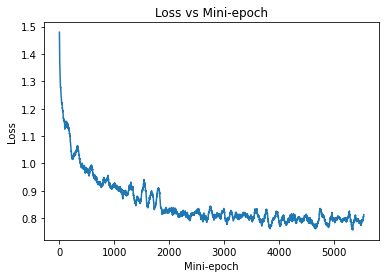

In [7]:
net = CustomNet5()
loss = anneal(net, data['train'], startingLR=0.0043, momentum=0.8348,
                           epochsPerLR=8, decay=0.021, numAnnealing=3)

print("Training accuracy: %f" % accuracy(net, data['train']))
print("Valid    accuracy: %f" % accuracy(net, data['valid']))
print("Testing  accuracy: %f" % accuracy(net, data['test']))

plt.title('Loss vs Mini-epoch')
plt.xlabel('Mini-epoch')
plt.ylabel('Loss')
plt.plot(smooth(loss, 50))

In [16]:
class CustomNet8(nn.Module):
    def __init__(self):
        super(CustomNet8, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # Input 64x64x1 image
        # 16 filters
        # 3x3 filter size (they also have 3 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 32x32x16
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=1)
        self.conv12 = nn.Conv2d(16, 16, 5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # Input 32x32x16 image
        # 32 filters
        # 3x3x16 filter size (they also have 16 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 16x16x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv22 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Exercise left to the reader
        # Output image: 8x8x64 -> 1024 neurons
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv32 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Exercise left to the reader
        # Output image: 8x8x128 -> 2048 neurons
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(8192, 14)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv12(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv22(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv32(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

100%|██████████| 8/8 [00:37<00:00,  4.64s/it]


Training accuracy: 0.751578
Valid    accuracy: 0.712674
Testing  accuracy: 0.715240


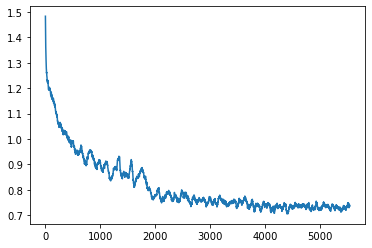

In [17]:
net8 = CustomNet8()
loss = anneal(net8, data['train'], startingLR=0.0043, momentum=0.8348,
                           epochsPerLR=8, decay=0.021, numAnnealing=3)

print("Training accuracy: %f" % accuracy(net8, data['train']))
print("Valid    accuracy: %f" % accuracy(net8, data['valid']))
print("Testing  accuracy: %f" % accuracy(net8, data['test']))

plt.plot(smooth(loss, 50))

In [14]:
class CustomNet10(nn.Module):
    def __init__(self):
        super(CustomNet10, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # Input 64x64x1 image
        # 16 filters
        # 3x3 filter size (they also have 3 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 32x32x16
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv12 = nn.Conv2d(16, 16, 5, stride=1, padding=1)
        # Input 32x32x16 image
        # 32 filters
        # 3x3x16 filter size (they also have 16 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 16x16x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv22 = nn.Conv2d(32, 32, 3, stride=1, padding=1)

        # Exercise left to the reader
        # Output image: 8x8x64 -> 1024 neurons
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv32 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        
        # Exercise left to the reader
        # Output image: 8x8x128 -> 2048 neurons
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(8192, 8192)
        self.fc2 = nn.Linear(8192, 8192)
        self.fc3 = nn.Linear(8192, 14)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv12(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv22(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv32(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

100%|██████████| 8/8 [01:34<00:00, 11.79s/it]


Training accuracy: 0.738485
Valid    accuracy: 0.720637
Testing  accuracy: 0.717668


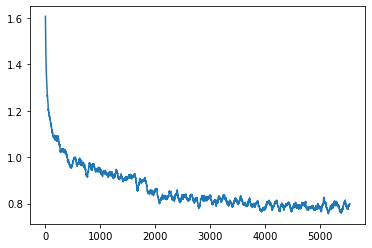

In [18]:
net10 = CustomNet10()
loss = anneal(net10, data['train'], startingLR=0.0043, momentum=0.8348,
                           epochsPerLR=8, decay=0.021, numAnnealing=3)

print("Training accuracy: %f" % accuracy(net10, data['train']))
print("Valid    accuracy: %f" % accuracy(net10, data['valid']))
print("Testing  accuracy: %f" % accuracy(net10, data['test']))

plt.plot(smooth(loss, 50))